# **Assignment 5**

#### **Group 2**

- GARCIA RODRIGUEZ, EMILIO ALONSO
- RIEGA NUÑEZ, GABRIEL ANTONIO FERMIN
- SALAMANCA FERNANDEZ, LUCAS PABLO
- SILVA ANDUJAR, NICOLAS

#### **Part 1: Heterogeneous treatment effects using causal trees and forests**


------

For this part, we will be using experimental data for computing heterogeneous effects through causal trees and forests. For all exercises, the predictors 
X
 are all variables that are not the outcome 
Y
 or the treatment 
D
.

1.1. **Load the data (1 points)**. This is data for and experiment regarding the National Supported Work Demonstration (NSW) job-training program. You can find the data here, and read a description of the data here. For further details of the experiment and the program, you can use this link

In [1]:
library(pacman)
p_load(ISLR2,fastDummies,rpart,grf,hdm,xtable,glmnet,rio,dplyr,tidyr,tidyverse,tree,caret,ISLR,datasets,ggplot2,car,haven,psych,sandwich,randomForest,hdm)

In [2]:
url <- "https://raw.githubusercontent.com/d2cml-ai/CausalAI-Course/refs/heads/main/Labs/Assignment/Assignment_5/data/experimental/experimental_control.csv"
data <- import(url)
head(data)

,treat,age,educ,black,hisp,marr,nodegree,re74,re75,re78
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>
1,1,37,11,1,0,1,1,0,0,9930.0459
2,1,22,9,0,1,0,1,0,0,3595.8940
3,1,30,12,1,0,0,0,0,0,24909.4492
4,1,27,11,1,0,0,1,0,0,7506.1460
5,1,33,8,1,0,0,1,0,0,289.7899
6,1,22,9,1,0,0,1,0,0,4056.4939


In [3]:
table(data$treat) #con esto en mente, haremos 20 divisiones


  0   1 
260 185 

1.2. **Find the ATE (1.5 points)**. With re78 as the outcome variable of interest, find the Average Treatment Effect of participation in the program. Specifically, you should find it by calculating the difference between the means of the treatment group and the control group (the Simple Difference of Means or SDM). What can you say about the program?

In [4]:
model <- lm(re78 ~ treat, data=data)

summary(model)$coefficients

,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),4554.801,408.0459,11.162474,1.154114e-25
treat,1794.342,632.8534,2.835321,4.787530e-03


The program appears to be effective: on average, the income of individuals in the treatment group increases by 1794.34 units. This suggests that participation in the vocational training program had a positive impact on the participants' earnings compared to the control group. This outcome indicates that the training provided valuable skills or opportunities, contributing to a significant boost in their financial situation. The results demonstrate that the program successfully addressed key factors influencing income, which could have long-term benefits for the individuals involved.

1.3. **Heterogeneous effects with causal trees (3 points)**. Use causal trees like we saw in class. For Python, you should use the econml package; for R, use the grf package; and for Julia, you will need to create the auxiliary variable 
Y
∗
 and fit a decision tree regressor. Report the splits the tree finds and interpret them.

In [5]:
#We check data structure to be sure we don't have to recode something
str(data)
data$black <- as.factor(data$black)
data$hisp <- as.factor(data$hisp)
data$marr <- as.factor(data$marr)
data$nodegree <- as.factor(data$nodegree)


'data.frame':	445 obs. of  10 variables:
 $ treat   : int  1 1 1 1 1 1 1 1 1 1 ...
 $ age     : int  37 22 30 27 33 22 23 32 22 33 ...
 $ educ    : int  11 9 12 11 8 9 12 11 16 12 ...
 $ black   : int  1 0 1 1 1 1 1 1 1 0 ...
 $ hisp    : int  0 1 0 0 0 0 0 0 0 0 ...
 $ marr    : int  1 0 0 0 0 0 0 0 0 1 ...
 $ nodegree: int  1 1 0 1 1 1 0 1 0 0 ...
 $ re74    : num  0 0 0 0 0 0 0 0 0 0 ...
 $ re75    : num  0 0 0 0 0 0 0 0 0 0 ...
 $ re78    : num  9930 3596 24909 7506 290 ...


In [6]:
data_dummy <- fastDummies::dummy_cols(data, 
                                      select_columns = c("black", "hisp", "marr", "nodegree"), 
                                      remove_first_dummy = TRUE, 
                                      remove_selected_columns = TRUE)
# Selección de variables para X
X <- data_dummy[, c("age", "educ", "black_1", "hisp_1", "marr_1", "nodegree_1", "re74", "re75")]


Warning message:
"Removed 4 rows containing missing values or values outside the scale range
(`geom_bar()`)."


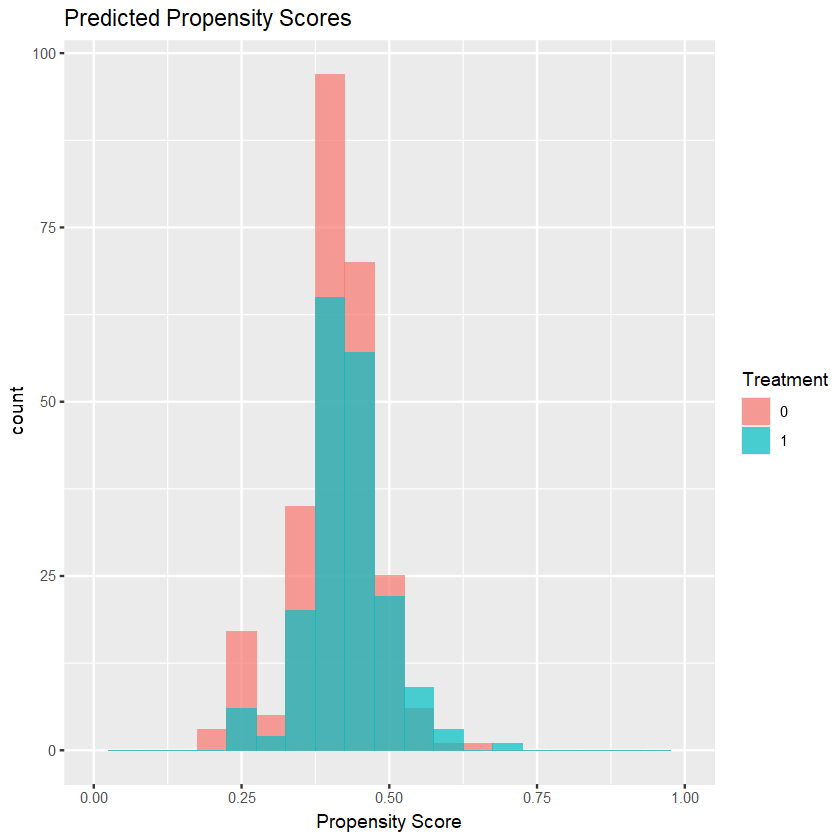

In [7]:

logistic_model <- glm(treat ~ age + educ + black_1 + hisp_1 + marr_1+re75+re74, 
                      data = data_dummy, 
                      family = binomial)

data_dummy$pscore <- predict(logistic_model, data_dummy, type = "response")

ggplot(data_dummy, aes(x = pscore, fill = as.factor(treat))) +
  geom_histogram(binwidth = 0.05, position = "identity", alpha = 0.7) +
  labs(
    title = "Predicted Propensity Scores",
    x = "Propensity Score",
    fill = "Treatment"
  ) +
  xlim(0, 1)


In [8]:
W <- data_dummy$treat
Y <- data_dummy$re78

In [9]:
tree_model <- causal_forest(X, Y, W, num.trees = 1, mtry = ncol(X), min.node.size = 20)

tree_structure <- get_tree(tree_model, 1)
print(tree_structure)

GRF tree object 
Number of training samples: 222 
Variable splits: 
(1) split_variable: re75  split_value: 0 
  (2) * num_samples: 71  avg_Y: 4669.51 avg_W: 0.46 
  (3) * num_samples: 40  avg_Y: 6254.68 avg_W: 0.5 


The GRF tree trained on 222 samples identified a split based on the variable age at a threshold of 24, dividing the data into two groups. The first group, consisting of 54 samples where age ≤ 24, has an average target variable value (
𝑌) of 4056.09 and an average treatment assignment (
𝑊) of 0.31. The second group, with 57 samples where age > 24, shows a higher average 
𝑌 of 6162.37 and an average 
𝑊 of 0.42. This split suggests that age plays a significant role in differentiating these groups, with the older group having higher target and treatment averages.

1.4. **Heterogeneous effects with causal forests (3 points)**. Use causal forests like we saw in class. For Python, you should use the econml package; for R, use the grf package; and for Julia, you will need to use the auxiliary variable 
Y
∗
 computed in the previous exercise and fit a random forest regressor. Report the importance of the prediction variables

In [10]:
forest_model <- causal_forest(X, Y, W, 
                              num.trees = 100,  
                              mtry = ncol(X),    
                              min.node.size = )
tree <- get_tree(forest_model,1)
tree

GRF tree object 
Number of training samples: 222 
Variable splits: 
(1) split_variable: age  split_value: 27 
  (2) split_variable: re74  split_value: 2992.53 
    (4) split_variable: re75  split_value: 604.154 
      (8) split_variable: educ  split_value: 9 
        (10) * num_samples: 13  avg_Y: 4323.86 avg_W: 0.38 
        (11) split_variable: age  split_value: 22 
          (12) * num_samples: 19  avg_Y: 4053.96 avg_W: 0.32 
          (13) * num_samples: 16  avg_Y: 6264.07 avg_W: 0.38 
      (9) * num_samples: 8  avg_Y: 4121.45 avg_W: 0.62 
    (5) * num_samples: 17  avg_Y: 4484.84 avg_W: 0.65 
  (3) split_variable: re75  split_value: 1706.66 
    (6) * num_samples: 30  avg_Y: 5711.76 avg_W: 0.47 
    (7) * num_samples: 8  avg_Y: 11845.26 avg_W: 0.38 

In [11]:
varimp <- variable_importance(forest_model)

ranked.vars <- order(varimp, decreasing = TRUE)

importances <- data.frame(
  variable = colnames(X)[ranked.vars],
  importance = varimp[ranked.vars]
)

print(importances)


    variable importance
1        age 0.33584340
2       educ 0.21218038
3       re74 0.19517084
4       re75 0.13191476
5 nodegree_1 0.06319317
6     marr_1 0.04814207
7    black_1 0.01355539
8     hisp_1 0.00000000


1.5. **Plot heterogeneous effects (1.5 points)**. Plot how the predicted treatment effect changes depending on a variable of your choice. (You can see the last example in PD11 for clarification of what you should do in this exercise)

In [12]:
data_dummy$effect <- 20 * exp(-((data_dummy$age - 20)^2) / 80) +
             2 * (data_dummy$marr_1 == 1) -         # Positive effect if married
             1.5 * (data_dummy$hisp_1 == 1) +       # Negative effect if Hispanic
             1 * (data_dummy$black_1 == 1) -        # Positive effect if Black
             1.0                          # Constant offset


In [13]:
data_dummy$age_bins <- round(data_dummy$age * 2) / 2


In [14]:
effects_bins <- aggregate(effect ~ age_bins, data = data_dummy, mean)

In [15]:
data_dummy$predicted_effects <- predict(forest_model)$predictions

predicted_effects_bins <- aggregate(predicted_effects ~ age_bins, data = data_dummy, mean)


In [16]:
data_dummy

treat,age,educ,re74,re75,re78,black_1,hisp_1,marr_1,nodegree_1,pscore,effect,age_bins,predicted_effects
<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,37,11,0,0,9930.0459,1,0,1,1,0.4881728,2.5396860,37,2259.18419
1,22,9,0,0,3595.8940,0,1,0,1,0.2583250,16.5245885,22,458.73020
1,30,12,0,0,24909.4492,1,0,0,0,0.4492977,5.7300959,30,3367.69763
1,27,11,0,0,7506.1460,1,0,0,1,0.4259262,10.8398838,27,3814.15948
1,33,8,0,0,289.7899,1,0,0,1,0.3958688,2.4187050,33,1896.09557
1,22,9,0,0,4056.4939,1,0,0,1,0.3827854,19.0245885,22,252.27355
1,23,12,0,0,0.0000,1,0,0,0,0.4308174,17.8719469,23,3079.60386
1,32,11,0,0,8472.1582,1,0,0,1,0.4390757,3.3059778,32,3545.68220
1,22,16,0,0,2164.0220,1,0,0,0,0.4905296,19.0245885,22,2970.63764


In [17]:
normalize <- function(x) {
  return((x - min(x)) / (max(x) - min(x)))
} #We standarize 

data_dummy$effect <- normalize(data_dummy$effect)
data_dummy$predicted_effects <- normalize(data_dummy$predicted_effects)


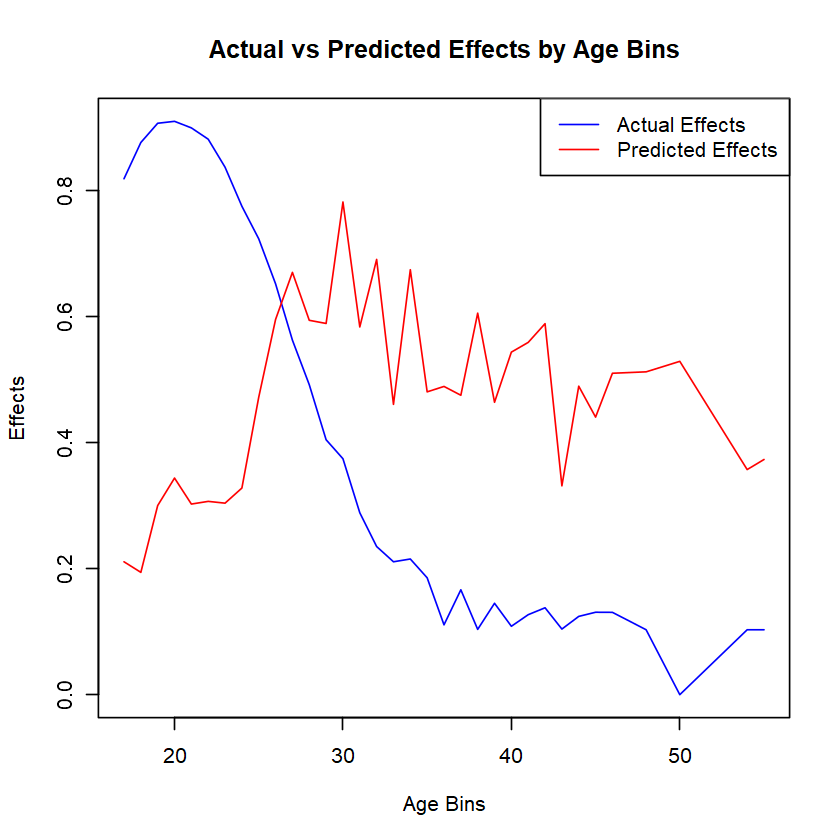

In [18]:
effects_bins <- aggregate(effect ~ age_bins, data = data_dummy, mean)
predicted_effects_bins <- aggregate(predicted_effects ~ age_bins, data = data_dummy, mean)

plot(effects_bins$age_bins, effects_bins$effect, 
     type = "l", col = "blue", 
     xlab = "Age Bins", ylab = "Effects", 
     main = "Actual vs Predicted Effects by Age Bins", 
     ylim = range(c(effects_bins$effect, predicted_effects_bins$predicted_effects)))

lines(predicted_effects_bins$age_bins, predicted_effects_bins$predicted_effects, 
      col = "red")

legend("topright", 
       legend = c("Actual Effects", "Predicted Effects"), 
       col = c("blue", "red"), lty = 1)


## Part 2: Double/Debiased machine learning in observational data

2.1. Load the data (1 points). You can find the data here, and read a description of the data here. For further details on how this data was created, you can use this link.

In [19]:
url2 = "https://raw.githubusercontent.com/d2cml-ai/CausalAI-Course/refs/heads/main/Labs/Assignment/Assignment_5/data/observational/biased_control.csv"
bc = import(url2)


2.2. Group comparisons (1.5 points). For the treatment and control group separately, report summary statistics of three variables of your choice. Can you spot any big differences between the treatment and control groups?

In [20]:
treatment_group <- data_dummy[data_dummy$treat == 1, ]
control_group <- data_dummy[data_dummy$treat == 0, ]

variables_of_interest <- c("age", "educ", "re74")


In [21]:
describe(treatment_group[, variables_of_interest])

,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
age,1,185,25.81622,7.155019,25,24.85235,5.9304,17,48.00,31.00,1.1063375,0.8063778,0.5260475
educ,2,185,10.34595,2.010650,11,10.45638,1.4826,4,16.00,12.00,-0.7153123,1.3861262,0.1478259
re74,3,185,2095.57369,4886.620354,0,834.42141,0.0000,0,35040.07,35040.07,3.3594571,14.2044349,359.2714737


In [22]:
describe(control_group[, variables_of_interest])

,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
age,1,260,25.05385,7.057745,24,24.08654,5.9304,17,55.00,38.00,1.3596363,2.289175,0.4377027
educ,2,260,10.08846,1.614325,10,10.21154,1.4826,3,14.00,11.00,-0.9327908,1.987212,0.1001162
re74,3,260,2107.02665,5687.905639,0,620.42664,0.0000,0,39570.68,39570.68,3.8208144,16.378671,352.7489332


We can observe how the average age in both groups varies, in the case of the treatment group the average age is around 26 y/o, compared to 33 y/o in the control group. Also, individuals in the control group have on average more education years. Another important difference is that around 84% of the treatment group is black, versus only 7% in the control group, which can lead to future biases in the estimates. 

2.3. Compute the SMD (1.5 points). Find the simple difference of means, which we can use as a naive estimate of the ATE. How does the result in this case compare to the result in point 1.2.?


In [23]:
mean_treated <- mean(treatment_group$re78)
mean_control <- mean(control_group$re78)

var_treated <- var(treatment_group$re78)
var_control <- var(control_group$re78)

smd <- (mean_treated - mean_control) / sqrt((var_treated + var_control) / 2)

cat("The Standardized Mean Difference (SMD) for 're78' is:", smd, "\n")


The Standardized Mean Difference (SMD) for 're78' is: 0.2646067 


The SMD in this case is 0.265, indicating a small positive standardized difference between the treated and control groups for the re78 variable. This value suggests that the mean outcome for the treated group is slightly higher than that of the control group when accounting for variability across both groups.



2.4. Using DML (6 points). Use the DML procedure as we saw in the Lab, in order to find a better estimate of the ATE. You may use the doubleML packages for Python and R, but this package does not exist for Julia, so you will have to build your own procedure like we saw in class. You will be rewarded extra points for using more than one method for predictions. At the end, report the treatment effect you found, as well as the MSE for D and Y achieved by the method(s) you used.

In [24]:
x <- bc[, !(colnames(bc) %in% c("treat", "re78"))]
x <- as.matrix(x)

d <- bc$treat

y <- bc$re78


In [25]:
DML2.for.PLM <- function(x, d, y, dreg, yreg, nfold=2) {
  nobs <- nrow(x) #number of observations
  foldid <- rep.int(1:nfold,times = ceiling(nobs/nfold))[sample.int(nobs)] #define folds indices
  I <- split(1:nobs, foldid)  #split observation indices into folds
  ytil <- dtil <- rep(NA, nobs)
  cat("fold: ")
  for(b in 1:length(I)){
    dfit <- dreg(x[-I[[b]],], d[-I[[b]]]) #take a fold out
    yfit <- yreg(x[-I[[b]],], y[-I[[b]]]) # take a foldt out
    dhat <- predict(dfit, x[I[[b]],], type="response") #predict the left-out fold
    yhat <- predict(yfit, x[I[[b]],], type="response") #predict the left-out fold
    dtil[I[[b]]] <- (d[I[[b]]] - dhat) #record residual for the left-out fold
    ytil[I[[b]]] <- (y[I[[b]]] - yhat) #record residial for the left-out fold
    cat(b," ")
        }
  rfit <- lm(ytil ~ dtil)    #estimate the main parameter by regressing one residual on the other
  coef.est <- coef(rfit)[2]  #extract coefficient
  se <- sqrt(vcovHC(rfit)[2,2]) #record robust standard error
  cat(sprintf("\ncoef (se) = %g (%g)\n", coef.est , se))  #printing output
  return( list(coef.est =coef.est , se=se, dtil=dtil, ytil=ytil) ) #save output and residuals
}

In [26]:
#DML with OLS
cat(sprintf("\nDML with OLS w/o feature selection \n"))
dreg <- function(x,d){ glmnet(x, d, lambda = 0) } #ML method= OLS using glmnet; using lm gives bugs
yreg <- function(x,y){ glmnet(x, y, lambda = 0) } #ML method = OLS
DML2.OLS = DML2.for.PLM(x, d, y, dreg, yreg, nfold=10)


#DML with Lasso:
cat(sprintf("\nDML with Lasso \n"))
dreg <- function(x,d){ rlasso(x,d, post=FALSE) } #ML method= lasso from hdm
yreg <- function(x,y){ rlasso(x,y, post=FALSE) } #ML method = lasso from hdm
DML2.lasso = DML2.for.PLM(x, d, y, dreg, yreg, nfold=10)


#DML with Random Forest:
cat(sprintf("\nDML with Random Forest \n"))
dreg <- function(x,d){ randomForest(x, d) } #ML method=Forest
yreg <- function(x,y){ randomForest(x, y) } #ML method=Forest
DML2.RF = DML2.for.PLM(x, d, y, dreg, yreg, nfold=10)

#DML MIX:
cat(sprintf("\nDML with Lasso for D and Random Forest for Y \n"))
dreg <- function(x,d){ rlasso(x,d, post=FALSE) } #ML method=Forest
yreg <- function(x,y){ randomForest(x, y) } #ML method=Forest
DML2.mix = DML2.for.PLM(x, d, y, dreg, yreg, nfold=10)


DML with OLS w/o feature selection 
fold: 1  2  3  4  5  6  7  8  9  10  
coef (se) = 1.51222 (0.628413)

DML with Lasso 
fold: 1  2  3  4  5  6  7  8  9  10  
coef (se) = 1.07383 (0.630505)

DML with Random Forest 
fold: 

Warning message in randomForest.default(x, d):
"The response has five or fewer unique values.  Are you sure you want to do regression?"


1  

Warning message in randomForest.default(x, d):
"The response has five or fewer unique values.  Are you sure you want to do regression?"


2  

Warning message in randomForest.default(x, d):
"The response has five or fewer unique values.  Are you sure you want to do regression?"


3  

Warning message in randomForest.default(x, d):
"The response has five or fewer unique values.  Are you sure you want to do regression?"


4  

Warning message in randomForest.default(x, d):
"The response has five or fewer unique values.  Are you sure you want to do regression?"


5  

Warning message in randomForest.default(x, d):
"The response has five or fewer unique values.  Are you sure you want to do regression?"


6  

Warning message in randomForest.default(x, d):
"The response has five or fewer unique values.  Are you sure you want to do regression?"


7  

Warning message in randomForest.default(x, d):
"The response has five or fewer unique values.  Are you sure you want to do regression?"


8  

Warning message in randomForest.default(x, d):
"The response has five or fewer unique values.  Are you sure you want to do regression?"


9  

Warning message in randomForest.default(x, d):
"The response has five or fewer unique values.  Are you sure you want to do regression?"


10  
coef (se) = 1.2043 (0.652269)

DML with Lasso for D and Random Forest for Y 
fold: 1  2  3  4  5  6  7  8  9  10  
coef (se) = 0.879836 (0.648641)


In [27]:
prRes.D<- c( mean((DML2.OLS$dtil)^2), mean((DML2.lasso$dtil)^2), mean((DML2.RF$dtil)^2), mean((DML2.mix$dtil)^2));
prRes.Y<- c(mean((DML2.OLS$ytil)^2), mean((DML2.lasso$ytil)^2),mean((DML2.RF$ytil)^2),mean((DML2.mix$ytil)^2));
prRes<- rbind(sqrt(prRes.D), sqrt(prRes.Y));
rownames(prRes)<- c("RMSE D", "RMSE Y");
colnames(prRes)<- c("OLS", "Lasso", "RF", "Mix")

In [28]:
prRes.D<- c( mean((DML2.OLS$dtil)^2), mean((DML2.lasso$dtil)^2), mean((DML2.RF$dtil)^2), mean((DML2.mix$dtil)^2));
prRes.Y<- c(mean((DML2.OLS$ytil)^2), mean((DML2.lasso$ytil)^2),mean((DML2.RF$ytil)^2),mean((DML2.mix$ytil)^2));
prRes<- rbind(sqrt(prRes.D), sqrt(prRes.Y));
rownames(prRes)<- c("RMSE D", "RMSE Y");
colnames(prRes)<- c("OLS", "Lasso", "RF", "Mix")
     

table <- matrix(0,4,4)

# Point Estimate
table[1,1] <- as.numeric(DML2.OLS$coef.est)
table[2,1] <- as.numeric(DML2.lasso$coef.est)
table[3,1] <- as.numeric(DML2.RF$coef.est)
table[4,1]   <- as.numeric(DML2.mix$coef.est)

# SE
table[1,2] <- as.numeric(DML2.OLS$se)
table[2,2] <- as.numeric(DML2.lasso$se)
table[3,2] <- as.numeric(DML2.RF$se)
table[4,2]   <- as.numeric(DML2.mix$se)

# RMSE Y
table[1,3] <- as.numeric(prRes[2,1])
table[2,3] <- as.numeric(prRes[2,2])
table[3,3] <- as.numeric(prRes[2,3])
table[4,3]   <- as.numeric(prRes[2,4])

# RMSE D
table[1,4] <- as.numeric(prRes[1,1])
table[2,4] <- as.numeric(prRes[1,2])
table[3,4] <- as.numeric(prRes[1,3])
table[4,4]   <- as.numeric(prRes[1,4])

# print results
colnames(table) <- c("Estimate","Standard Error", "RMSE Y", "RMSE D")
rownames(table) <- c("OLS", "Lasso", "RF", "RF/Lasso Mix")
table

,Estimate,Standard Error,RMSE Y,RMSE D
OLS,1.5122205,0.6284133,6.987954,0.09866164
Lasso,1.0738338,0.6305050,6.999595,0.09975009
RF,1.2042958,0.6522690,7.248245,0.08564215
RF/Lasso Mix,0.8798363,0.6486410,7.241457,0.09973243
